In [1]:
from gurobipy import *
from passenger import *
import pandas as pd

import matplotlib.pyplot as plt
import itertools
import random

In [2]:
# Load Passengers

df = read_and_preprocess('DataSeating - V3.xlsx', '21Oct')

groups = get_list_passengers(df)

passengers = list()

for g in groups.keys():
    passengers += groups[g].members

passenger_from_id = {}
for p in passengers:
    passenger_from_id[p.passenger_id] = p

In [3]:

passengers_count = len(passengers)

width = 6
height = 28
X = [-3, -2, -1, 0, 1, 2, 3]
Y = list(range(-14,0)) + list(range(1,14+1))

total_weight = sum(p.weight for p in passengers)


In [4]:
m = Model("model_v1")

# Allocation Variables
allocation = m.addVars(passengers_count, width+1, height, vtype=GRB.BINARY, name="Allocation")

# Make sure that there is at most one person per seat
C_limited_seat = m.addConstrs((quicksum([allocation[p.passenger_id,i,j] for p in passengers]) <= 1 for i in range(width+1) for j in range(height)))

# Maker sure that everyone is seated and only in one spot
C_serve_all = m.addConstrs((quicksum([allocation[p.passenger_id,i,j] for i in range(width+1) for j in range(height) ]) == 1 for p in passengers))

# Make sure that the corridor is not considered as a possible seat
C_empty_corridor = m.addConstrs((0 == allocation[p,3,j] for p in range(passengers_count) for j in range(height)))


# Center of Mass function
barycenter_X = quicksum([p.weight * allocation[p.passenger_id,i,j]*X[i] for p in passengers for i in range(width+1) for j in range(height)])/total_weight
barycenter_Y = quicksum([p.weight * allocation[p.passenger_id,i,j]*Y[j] for p in passengers for i in range(width+1) for j in range(height)])/total_weight

# Barycenter limits
bary_lim_X = 1
bary_lim_Y = 2

# Make sure that the center of mass is centralized

C_bary_X_p = m.addConstr(barycenter_X <=  bary_lim_X)
C_bary_X_m = m.addConstr(barycenter_X >= -bary_lim_X)
C_bary_Y_p = m.addConstr(barycenter_Y <=  bary_lim_Y)
C_bary_Y_m = m.addConstr(barycenter_Y >= -bary_lim_Y)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-27


In [7]:
i_p = m.addVars(passengers_count, vtype=GRB.INTEGER, lb=0, ub=width, name="i_p")
j_p = m.addVars(passengers_count, vtype=GRB.INTEGER, lb=0, ub=height, name="j_p")

i_g_max = m.addVars(len(groups), vtype=GRB.INTEGER, lb=0, ub=width, name="i_g_max")
i_g_min = m.addVars(len(groups), vtype=GRB.INTEGER, lb=0, ub=width, name="i_g_min")
j_g_max = m.addVars(len(groups), vtype=GRB.INTEGER, lb=0, ub=height, name="j_g_max")
j_g_min = m.addVars(len(groups), vtype=GRB.INTEGER, lb=0, ub=height, name="j_g_min")

i_g_delta = m.addVars(len(groups), vtype=GRB.INTEGER, lb=0, ub=width, name="i_g_delta")
j_g_delta = m.addVars(len(groups), vtype=GRB.INTEGER, lb=0, ub=height, name="j_g_delta")

m.addConstrs((i_p[p] == quicksum([i*allocation[p,i,j] for i in range(width+1) for j in range(height)]) for p in range(passengers_count)))
m.addConstrs((j_p[p] == quicksum([j*allocation[p,i,j] for i in range(width+1) for j in range(height)]) for p in range(passengers_count)))

for g in range(len(groups)):
    if len(groups[g].members) > 1 and  len(groups[g].members)  <= 3:
    
        m.addConstrs(( i_g_max[g] >= i_p[p.passenger_id] for p in groups[g].members ))
        m.addConstrs(( i_g_min[g] <= i_p[p.passenger_id] for p in groups[g].members ))
        m.addConstrs(( j_g_max[g] >= j_p[p.passenger_id] for p in groups[g].members ))
        m.addConstrs(( j_g_min[g] <= j_p[p.passenger_id] for p in groups[g].members ))
        
        m.addConstr(i_g_delta[g] == i_g_max[g] - i_g_min[g])
        m.addConstr(j_g_delta[g] == j_g_max[g] - j_g_min[g])


def in_grid(i, j):
    return i>=0 and j>=0 and j<height and i <= width

e_allocation = lambda p, i, j: allocation[p,i,j] if in_grid(i,j) else 0




m.setObjective( j_g_delta.sum(), GRB.MINIMIZE)

m.update()

m.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 5851 rows, 31532 columns and 283234 nonzeros
Model fingerprint: 0x0d25c3f3
Variable types: 0 continuous, 31532 integer (29596 binary)
Coefficient statistics:
  Matrix range     [6e-03, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+00]

MIP start from previous solve produced solution with objective 313 (0.07s)
Loaded MIP start from previous solve with objective 313

Presolve removed 5293 rows and 6029 columns
Presolve time: 0.31s
Presolved: 558 rows, 25503 columns, 107599 nonzeros
Variable types: 2 continuous, 25501 integer (25368 binary)

Root relaxation: objective 1.332268e-14, 1172 iterations, 0.12 seconds (0.11 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time



Center of Mass: (0.03, -0.4)
ID:0 - (2, 12)/(5, 25) Sats: satisfaction[a[0]].x
ID:1 - (-2, 8)/(1, 21) Sats: satisfaction[a[0]].x
ID:2 - (1, 3)/(4, 16) Sats: satisfaction[a[0]].x
ID:3 - (3, -13)/(6, 1) Sats: satisfaction[a[0]].x
ID:4 - (-2, -13)/(1, 1) Sats: satisfaction[a[0]].x
ID:5 - (1, -13)/(4, 1) Sats: satisfaction[a[0]].x
ID:6 - (-3, -7)/(0, 7) Sats: satisfaction[a[0]].x
ID:7 - (-2, 4)/(1, 17) Sats: satisfaction[a[0]].x
ID:8 - (3, -12)/(6, 2) Sats: satisfaction[a[0]].x
ID:9 - (-3, -12)/(0, 2) Sats: satisfaction[a[0]].x
ID:10 - (1, 4)/(4, 17) Sats: satisfaction[a[0]].x
ID:11 - (3, 10)/(6, 23) Sats: satisfaction[a[0]].x
ID:12 - (2, -9)/(5, 5) Sats: satisfaction[a[0]].x
ID:13 - (-2, -9)/(1, 5) Sats: satisfaction[a[0]].x
ID:14 - (3, 4)/(6, 17) Sats: satisfaction[a[0]].x
ID:15 - (-2, -5)/(1, 9) Sats: satisfaction[a[0]].x
ID:16 - (2, -5)/(5, 9) Sats: satisfaction[a[0]].x
ID:17 - (-3, -5)/(0, 9) Sats: satisfaction[a[0]].x
ID:18 - (3, 2)/(6, 15) Sats: satisfaction[a[0]].x
ID:19 - (-1, 11)

(-3.5, 3.5)

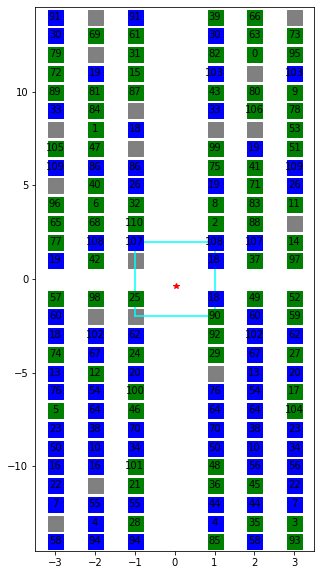

In [8]:
cm_x = round(barycenter_X.getValue(),2)
cm_y = round(barycenter_Y.getValue(),2)

print(f"Center of Mass: {(cm_x, cm_y)}")


fig = plt.figure(figsize=(5,10));
for seat in itertools.product(X,Y):
    if seat[0] != 0:
        plt.plot(seat[0],seat[1],'s', color="gray", markersize=15)

plt.plot([bary_lim_X, bary_lim_X]  , [-bary_lim_Y, bary_lim_Y],   color="cyan")
plt.plot([-bary_lim_X, -bary_lim_X], [-bary_lim_Y, bary_lim_Y],   color="cyan")
plt.plot([-bary_lim_X, bary_lim_X] , [bary_lim_Y, bary_lim_Y],    color="cyan")
plt.plot([-bary_lim_X, bary_lim_X] , [-bary_lim_Y, -bary_lim_Y],   color="cyan")

#for g in range(len(groups)):
    #print(j_g_max[g].x, j_g_min[g].x)

for a in allocation:
    if allocation[a].x == 1:
        
        if len(groups[passenger_from_id[a[0]].group_index].members) == 1:
            color = "green"
        else:
            color = "blue"
            
        
        #plt.plot(X[a[1]],Y[a[2]], 'o',color=colors[passengers[a[0]].group_index-1])
        plt.plot(X[a[1]], Y[a[2]], 's', color=color, markersize=15)
        plt.text(X[a[1]], Y[a[2]],passengers[a[0]].group_index, ha="center", va="center")
        print(f"ID:{a[0]} - {(X[a[1]], Y[a[2]])}/{(a[1], a[2])} Sats: satisfaction[a[0]].x")
plt.plot(cm_x,cm_y, "*", color="red")
plt.ylim([-14.5,14.5])
plt.xlim([-3.5,3.5])